In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.hopkins import hopkins
from src.model_fit import do_StepMix, do_kmeans, do_AHC, do_hdbscan
from src.model_plot import plot_clusters, plot_cluster_profiles

In [2]:
CVI = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
approach = 'replic_830'

# Data

In [3]:
var_list = [
    'clseusa', 'ambornin', 'amcit', 'amlived', 'amenglsh', 'amchrstn',
    'amgovt', 'amfeel', 'amcitizn', 'amshamed', 'belikeus', 'ambetter',
    'ifwrong', 'proudsss', 'proudgrp', 'proudpol', 'prouddem', 'proudeco',
    'proudspt', 'proudart', 'proudhis', 'proudmil', 'proudsci']

if approach == 'own':
    var_list.extend(['clsetown', 'clsestat', 'clsenoam', 'amancstr', 'amsports', 'lessprd'])

var_list_f = [var + "_f" for var in var_list]
var_list_n = [var + "_n" for var in var_list]

ctrl_list = [
    'party_f', 'race_f', 'educ_f', 'region_f', 'reltrad_f', 'religstr_f', 
    'born_usa_f', 'sex_f', 'age_n', 'lnrealinc2004_n', 'age_n', 'lnrealinc2004_n']

In [4]:
if '830' in approach:
    data2004 = pd.read_parquet(f"data/data2004_830.parquet")
elif '1077' in approach:
    data2004 = pd.read_parquet(f"data/data2004_1077.parquet")
else:
    data2004 = pd.read_parquet(f"data/data2004_1215.parquet")

# Dataset with numeric outcomes
data_n = data2004[var_list_n]

# Dataset with categorical outcomes and reindexing to 0 (as expected by StepMix)
data_f = data_n - 1

# Dataset with controls (same as the authors)
controls = data2004[ctrl_list]
controls_dum = pd.get_dummies(controls)

# Sample weights
weights = data2004['wgt']

In [5]:
all_models = pd.read_csv(f"output/models/all_models_{approach}.csv")
candidate_models = pd.read_csv(f"output/models/candidate_models_{approach}.csv")

# Convert params to dictionary to avoid errors afterwards
if isinstance(all_models['params'].iloc[0], str):
    all_models['params'] = all_models['params'].apply(ast.literal_eval)
if isinstance(candidate_models['params'].iloc[0], str):
    candidate_models['params'] = candidate_models['params'].apply(ast.literal_eval)

# Compare CVI

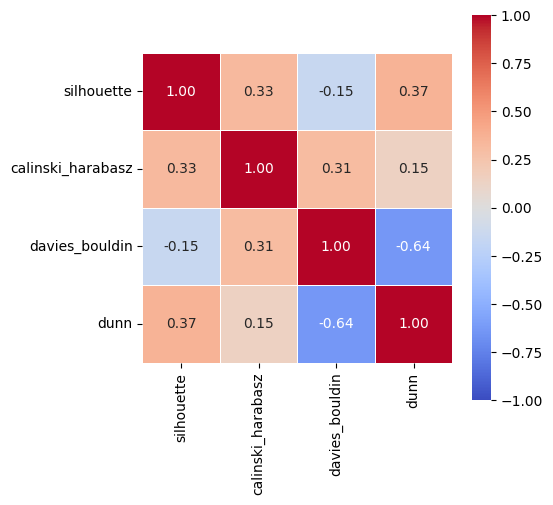

In [6]:
all_CVI = all_models[['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']]
correlations = all_CVI.corr(method='spearman')

plt.figure(figsize=(5, 5)) 
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.show()

# Identify best models
## 1. According to the gap stat for latent analysis / kmeans / AHC (step 3)

In [7]:
models = ['kmeans', 'AHC', 'latent']
CVI_results = {}

for index in CVI:
    CVI_results[index] = []
    df = candidate_models[candidate_models[f'{index}_gap'] == 1]
    
    for model in models:
        sub_df = df[df['model'] == model]

        if sub_df.empty:
            continue
        else:
            if index == 'davies_bouldin':
                best_mod = sub_df.sort_values(index, ascending=True).iloc[0]
            else:
                best_mod = sub_df.sort_values(index, ascending=False).iloc[0]
            CVI_results[index].append(best_mod)

In [8]:
best_sil = pd.DataFrame(CVI_results['silhouette'])
best_ch = pd.DataFrame(CVI_results['calinski_harabasz'])
best_db = pd.DataFrame(CVI_results['davies_bouldin'])
best_dunn = pd.DataFrame(CVI_results['dunn'])

## 2. According to the min/max rule for HDBSCAN

In [9]:
hdbscan_all = all_models[all_models['model'] == 'HDBSCAN'].copy()
hdbscan_all = hdbscan_all.drop(columns=['aic', 'bic', 'sabic', 'relative_entropy', 'classif_error', 'df', 'LL'])

In [10]:
best_sil = pd.concat([best_sil, hdbscan_all.sort_values('silhouette', ascending=False).iloc[0:1]], axis=0)
best_ch = pd.concat([best_ch, hdbscan_all.sort_values('calinski_harabasz', ascending=False).iloc[0:1]], axis=0)
best_db = pd.concat([best_db, hdbscan_all.sort_values('davies_bouldin', ascending=True).iloc[0:1]], axis=0)
best_dunn = pd.concat([best_dunn, hdbscan_all.sort_values('dunn', ascending=False).iloc[0:1]], axis=0)

In [11]:
best_sil = best_sil.drop(columns=[col for col in best_sil.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_ch = best_ch.drop(columns=[col for col in best_ch.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_db = best_db.drop(columns=[col for col in best_db.columns if col.endswith(('elbow', 'abs', 'gap'))])
best_dunn = best_dunn.drop(columns=[col for col in best_dunn.columns if col.endswith(('elbow', 'abs', 'gap'))])

# Results

## 1. Silhouette

In [12]:
def refit_best_model(df):
    model = df.loc[0, 'model']
    config = df.loc[0, 'params']
    n_clust = int(df.loc[0, 'n_clust'])

    if model == 'latent':
        results = do_StepMix(
            data = data_f if config['msrt'] == 'categorical' else data_n,
            controls = controls_dum if config['covar'] == 'with' else None,
            n = n_clust,
            refit = True, 
            **config)
    
    elif model == 'kmeans':
        results = do_kmeans(data_n, n_clust, refit = True, **config)
    
    elif model == 'AHC':
        results = do_AHC(data_n, n_clust, refit = True, **config)
    
    elif model == 'HDBSCAN':
        results = do_hdbscan(data_n, refit = True, **config)

    return results

In [13]:
sil = best_sil.sort_values('silhouette', ascending=False).drop(columns=['calinski_harabasz', 'davies_bouldin', 'dunn']).reset_index(drop=True)
sil.style

,model,params,n_clust,silhouette,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'euclidean', 'link': 'average'}",4,0.512324,1.000000,822.000000,nan
1,HDBSCAN,"{'dist': 'hamming', 'min_clust': 3, 'min_smpl': 1}",2,0.509037,3.000000,823.000000,0.361446
2,kmeans,"{'dist': 'manhattan', 'link': 'mean'}",15,0.114115,10.000000,194.000000,nan
3,latent,"{'msrt': 'categorical', 'covar': 'without'}",13,0.045339,19.000000,123.000000,nan


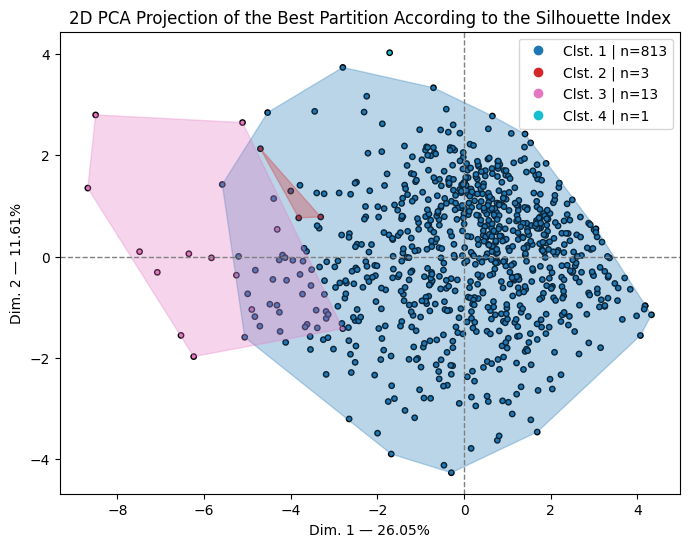

In [14]:
pred_clust_sil = refit_best_model(sil)

plot_clusters(
    data = data_f if (sil.loc[0, 'model'] == 'latent' and sil.loc[0, 'params'].get('msrt') == 'categorical') else data_n,
    pred_clust = pred_clust_sil,
    title = '2D PCA Projection of the Best Partition According to the Silhouette Index',
    filename = f'best_sil_{approach}')

if np.unique(pred_clust_sil, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_sil, feature_names = var_list, sd = 1, title = 'Silhouette', filename = f'best_sil_{approach}')

## 2. Calinski-Harabasz

In [15]:
ch = best_ch.sort_values('calinski_harabasz', ascending=False).drop(columns=['silhouette', 'davies_bouldin', 'dunn']).reset_index(drop=True)
ch.style

,model,params,n_clust,calinski_harabasz,min_clust_size,max_clust_size,noise
0,kmeans,"{'dist': 'euclidean', 'link': 'medoid'}",6,69.646820,76.000000,239.000000,nan
1,HDBSCAN,"{'dist': 'hamming', 'min_clust': 2, 'min_smpl': 13}",2,57.324092,2.000000,591.000000,28.554217
2,latent,"{'msrt': 'categorical', 'covar': 'without'}",10,45.167211,11.000000,124.000000,nan
3,AHC,"{'dist': 'euclidean', 'link': 'ward'}",14,40.370725,23.000000,125.000000,nan


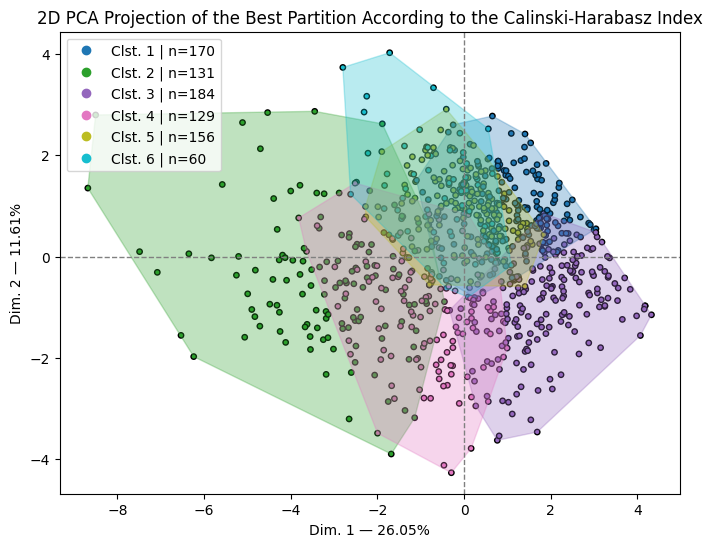

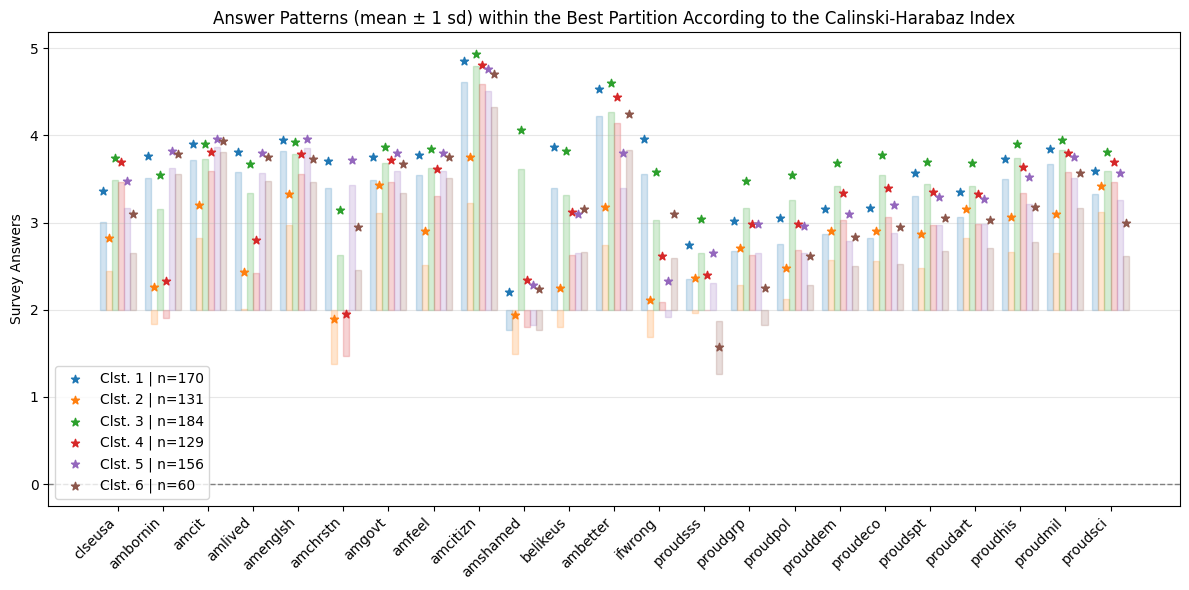

In [16]:
pred_clust_ch = refit_best_model(ch)

plot_clusters(
    data = data_f if (ch.loc[0, 'model'] == 'latent' and ch.loc[0, 'params'].get('msrt') == 'categorical') else data_n,
    pred_clust = pred_clust_ch,
    title = '2D PCA Projection of the Best Partition According to the Calinski-Harabasz Index',
    filename = f'best_ch_{approach}')

if np.unique(pred_clust_ch, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_ch, feature_names = var_list, sd = 1, title = 'Calinski-Harabaz', filename = f'best_ch_{approach}')

## 3. Davies-Bouldin

In [17]:
db = best_db.sort_values('davies_bouldin', ascending=True).drop(columns=['silhouette', 'calinski_harabasz', 'dunn']).reset_index(drop=True)
db.style

,model,params,n_clust,davies_bouldin,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'chebyshev', 'link': 'single'}",6,0.400803,1.000000,825.000000,nan
1,HDBSCAN,"{'dist': 'euclidean', 'min_clust': 5, 'min_smpl': 7}",2,1.182516,6.000000,816.000000,98.313253
2,kmeans,"{'dist': 'euclidean', 'link': 'mean'}",9,2.479102,24.000000,142.000000,nan
3,latent,"{'msrt': 'categorical', 'covar': 'without'}",14,2.850445,15.000000,127.000000,nan


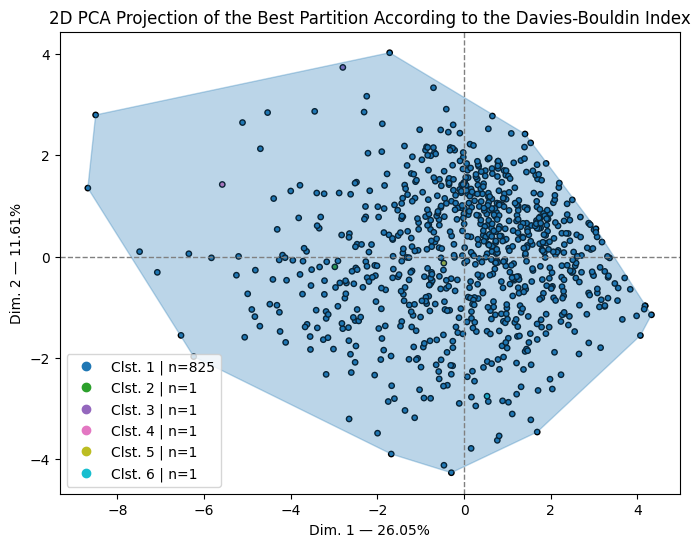

In [18]:
pred_clust_db = refit_best_model(db)

plot_clusters(
    data = data_f if (db.loc[0, 'model'] == 'latent' and db.loc[0, 'params'].get('msrt') == 'categorical') else data_n,
    pred_clust = pred_clust_db,
    title = '2D PCA Projection of the Best Partition According to the Davies-Bouldin Index',
    filename = f'best_db_{approach}')

if np.unique(pred_clust_db, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_db, feature_names = var_list, sd = 1, title = 'Davies-Bouldin', filename = f'best_db_{approach}')

## 4. Generalized Dunn 43

In [19]:
gd = best_dunn.sort_values('dunn', ascending=False).drop(columns=['silhouette', 'calinski_harabasz', 'davies_bouldin']).reset_index(drop=True)
gd.style

,model,params,n_clust,dunn,min_clust_size,max_clust_size,noise
0,AHC,"{'dist': 'hamming', 'link': 'single'}",4,2.138201,1.000000,827.000000,nan
1,HDBSCAN,"{'dist': 'hamming', 'min_clust': 4, 'min_smpl': 1}",2,1.082919,3.000000,823.000000,0.361446
2,latent,"{'msrt': 'categorical', 'covar': 'without'}",3,0.615614,195.000000,331.000000,nan
3,kmeans,"{'dist': 'euclidean', 'link': 'median'}",4,0.374711,116.000000,256.000000,nan


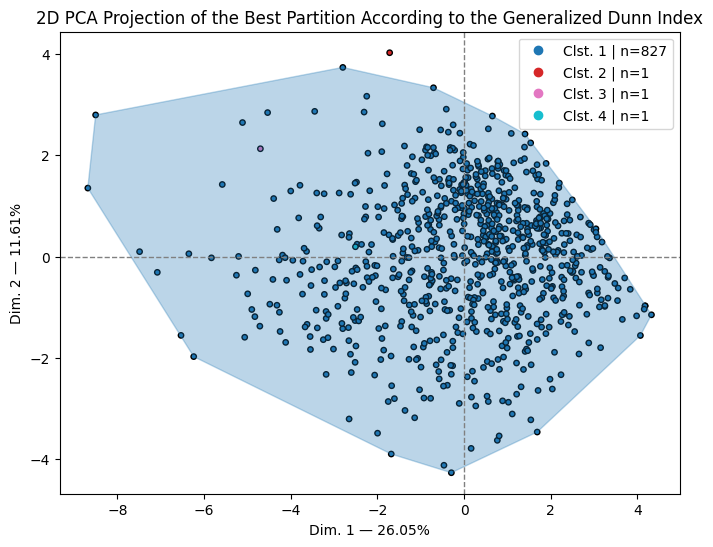

In [20]:
pred_clust_gd = refit_best_model(gd)

plot_clusters(
    data = data_f if (gd.loc[0, 'model'] == 'latent' and gd.loc[0, 'params'].get('msrt') == 'categorical') else data_n,
    pred_clust = pred_clust_gd,
    title = '2D PCA Projection of the Best Partition According to the Generalized Dunn Index',
    filename = f'best_gd_{approach}')

if np.unique(pred_clust_gd, return_counts=True)[1].min() > 5:
    plot_cluster_profiles(data_n, pred_clust_gd, feature_names = var_list, sd = 1, title = 'Generalized Dunn', filename = f'best_gb_{approach}')

# 5. Hopkins Statistic

In [21]:
hopkins_stat = hopkins(data_n.values, data_n.shape[0])
print(f"Hopkins stat: {hopkins_stat:.3f}")

Hopkins stat: 0.358
